## Mask R-CNN - Simulate the `DetectionTargetLayer` Process

We generate the inputs to `DetectTargetLayer` , to manipulate and modify the layer to procduce a modified `output_rois` 
containing false positives. 
This will be passed on the the heatmap layer, and through there will become the input to FCN.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:94% !important; }</style>"))

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import  gc
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pprint
import keras.backend as KB
import keras.layers as KL
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 

from mrcnn.utils       import stack_tensors, stack_tensors_3d
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.visualize   import plot_gaussian
# from mrcnn.pc_layer    import PCTensor
# from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4)


# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 1                  # Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 1                  # Must match BATCH_SIZE
config.STEPS_PER_EPOCH = 2
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
config.display() 

# Build shape dataset        -----------------------------------------------
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

try :
    del model, train_generator, val_generator, mm
    gc.collect()
except: 
    pass
# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print(' COCO Model Path       : ', COCO_MODEL_PATH)
print(' Checkpoint folder Path: ', MODEL_DIR)

# sess = tf.InteractiveSession()
# KB.set_session(sess)
# # Create Model

try :
    del model
    gc.collect()
except: 
    pass
# KB.clear_session()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
#model.keras_model.summary(line_length = 120) 

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.4 
 Initialize config object - super

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS_TO_RUN                  0
FCN_INPUT_SHAPE                [128 128]
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8

    after transpose  (128, 128, 1, 100, 2)
    pt2_sum shape  (1, 4, 100)
    dense shape  (?, 6)
    Build Stacked output from dynamically partitioned lists --------------
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, 1, 100, 2)
    << output probabilities shape: (?, 100, 128, 128)

    Scatter out the probability distributions based on class --------------
    gaussian_grid      :  (?, 100, 128, 128)
    class shape        :  (1, ?)
    roi_grid shape     :  (1, 100)
    batch_grid shape   :  (1, 100)
    scatter_classes    :  (1, 100, 3)
    gaussian scattered :  (1, 4, 100, 128, 128)

    Reduce sum based on class ---------------------------------------------
    gaussian sum type/name :  <class 'tensorflow.python.framework.ops.Tensor'> cntxt_layer/gt_gaussian:0 gt_gaussian
    gaussian_sum shape     :  (1, 128, 128, 4) Keras tensor  False

    Output build_gaussian_tf 
     pred_gaussian :  (1, 128, 128, 4) Keras tensor  False
     gt_gaussian   :  (1, 128, 128,

In [30]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)
print('Load weights complete')

>>> load_weights()
    load_weights: Loading weights from: E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
    load_weights: Log directory set to : E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 5785 
    Load weights complete :  E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5784.h5
Load weights complete


###  Print some model information 

In [ ]:
# print('\n Learning phase values is L ' ,KB.learning_phase())
# print('\n Metrics (_get_deduped_metrics_names():) ') 
# pp.pprint(model.keras_model._get_deduped_metrics_names())
print('\n Outputs: ') 
for i,x in enumerate(model.keras_model.outputs):
    print(' layer: {:2d}    output : {:40s}   Type: {}       Shape: {}'.format( i, x.name, x.dtype, x.shape) )
# print('\n Losses (model.metrics_names): ') 
# pp.pprint(model.keras_model.metrics_names)

# model.keras_model.summary(line_length = 150) 

print(model.keras_model)


### Define Data Generator

In [4]:
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

### Get next shapes from generator and display loaded shapes

Image id:  480
Image meta [480 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 1 2 1]


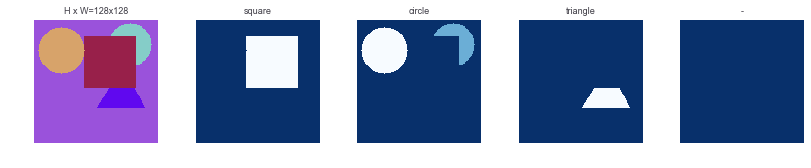

In [16]:
train_batch_x, train_batch_y = next(train_generator)

### Display loaded shapes

# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)



### Push Data thru model using get_layer_output()

In [ ]:

# layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1)


###  Build input tensors from `train_batch_x` which is the input to the model 

In [35]:
input_image, input_image_meta, input_rpn_match ,  input_rpn_bbox  ,  input_gt_class_ids, input_gt_boxes,  \
input_gt_masks     =  train_batch_x

h, w = input_image.shape[0], input_image.shape[1]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
input_normlzd_gt_boxes = tf.identity(input_gt_boxes / image_scale)

rpn_proposal_rois = get_layer_output_1(model.keras_model, train_batch_x, [3], verbose = True)

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 12)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)
Input  6:  (input_gt_masks:0                        ) 	  Input shape: (1, 56, 56, 100)

/* Outputs */
Output  3: (rpn_proposal_rois/packed_2:0            ) 	  Output shape: (1, 2000, 4)


In [36]:
print(input_gt_boxes.shape, input_image.shape)
print(rpn_proposal_rois.shape)
print((rpn_proposal_rois[0,:5,:]*[128,128,128,128]))

(1, 100, 4) (1, 128, 128, 3)
(1, 2000, 4)
[[  8.5559   6.8063  53.2904  51.8479]
 [ 33.032   42.799   88.2882  99.7937]
 [ 12.5507  41.7644  68.7552  98.664 ]
 [ 33.9294  57.2783  86.9869 113.6012]
 [  9.0826  61.0126  67.2181 118.2515]]


In [ ]:
# sess.close()
# sess = tf.InteractiveSession()
# KB.set_session(sess)

###  Setup tensors to be passed to `detections_target_graph()`

This is passed to the DetectionTargetLayer


In [19]:
import mrcnn.utils  as utils
from mrcnn.detect_tgt_layer import overlaps_graph
# proposals    = KB.identity(rpn_proposal_rois)[0]
# gt_class_ids = KB.identity(input_gt_class_ids)[0]
# gt_boxes     = KB.identity(input_normlzd_gt_boxes)[0]
# gt_masks     = KB.identity(input_gt_masks)[0]

# proposals    = rpn_proposal_rois[1]
# gt_class_ids = input_gt_class_ids[1]
# gt_boxes     = input_normlzd_gt_boxes[1]
# gt_masks     = input_gt_masks[1]
# config       = model.config

### def `dev_detection_targets_graph`

In [43]:
def dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):


    print('>>> detection_targets_graph ')
    print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
    print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
    print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
    print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

    proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
    gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
    gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

    # print(tf.shape(proposals).eval())
    # print(non_zeros.eval())
    # print('gt_boxes :', tf.shape(gt_boxes).eval())

    ###  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications

    crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
    crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
    crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
    gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)
    # Compute overlaps with crowd boxes [anchors, crowds]
    crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
    no_crowd_bool   = (crowd_iou_max < 0.001)

    # print('crowd ixs: ', crowd_ix.eval())
    # print('non_crowrd_ixs', non_crowd_ix.eval())
    # print('non crowd bool', no_crowd_bool.eval())

    overlaps        = overlaps_graph(proposals, gt_boxes)
    print('     overlaps.shape :',  tf.shape(overlaps).eval())
    
    roi_iou_max            = tf.reduce_max(overlaps, axis=1)
    print(' RoI/Gt max IoU')
    # print(roi_iou_max.eval())
    positive_roi_bool     = (roi_iou_max >= 0.5)
    all_positive_indices      = tf.where(positive_roi_bool) [:, 0]
    print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
    print('Positive IoUs \n', tf.gather(roi_iou_max,all_positive_indices).eval())

    ## current method
    all_negative_indices     = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]
#     print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
#     print('Negative IoUs \n', tf.gather(roi_iou_max,all_negative_indices).eval())

    ## method - suppress the proposals with 0 IoUs
    # negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
    # negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
    # negative_nonzero_indices      = tf.where(negative_nonzero_bool) [:, 0]
    # print('Negative indices')
    # print(tf.shape(negative_nonzero_indices).eval(),'\n',negative_nonzero_indices.eval())
    # print(tf.gather(roi_iou_max,negative_nonzero_indices).eval())

    ##------------------------------------------------------------------------------------------------------
    ## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
    ##    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
    ##    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE --> 10
    ##------------------------------------------------------------------------------------------------------
    # print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
    # print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
    # print(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO )
    # print(' Postive count using Ceiling : ', tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ).eval())

    positive_ind_shuffled  = tf.random_shuffle(all_positive_indices, seed=1 )
    negative_ind_shuffled  = tf.random_shuffle(all_negative_indices, seed=1 )
    print('Shuffled Pos indices :',tf.shape(positive_ind_shuffled).eval(),'\n',positive_ind_shuffled.eval())
#     print('Shuffled Neg indices :',tf.shape(negative_ind_shuffled).eval(),'\n',negative_ind_shuffled.eval())

    ##------------------------------------------------------------------------------------------------------
    ##  Select positive samples from amongst positive bounding boxes
    ##------------------------------------------------------------------------------------------------------
    ## current method
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
    ## alternative option -round upwards using ceiling
#     positive_count        = tf.cast(tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ), tf.int32)
#     positive_indices      = tf.random_shuffle(positive_indices,seed = 1)[:true_positive_count]

    ## New:
    positive_indices      = positive_ind_shuffled[:positive_count]
    positive_count        = tf.shape(positive_indices)[0]

#     print('Selected Positive Indices: ',positive_count.eval())
#     print(positive_indices.eval())
#     print('Positive indices: \n',positive_indices.eval())

    ##------------------------------------------------------------------------------------------------------
    ##   4. Add Negative ROIs. Add enough to maintain positive:negative ratio
    ##
    ## The current method to compute the negative_count in Mask_RCNN seems to result in a shortage of the 
    ## negative count, due to the fact that positive_count is cast to an int. 
    ## for eg. int(32 * 0.333) = int(10.56) = 10. 
    ## 
    ## This results in a negative_count of 1/0.33 * 10 = 30. (2 short of 32)
    ## To resolve this we subtract the postivie count from  TRAIN_ROIS_PER_IMAGE to obtain the all_negs_count
    ## some of these will be used to introduce false positives/
    ##------------------------------------------------------------------------------------------------------
    # r = 1.0 / config.ROI_POSITIVE_RATIO
    # print(' r * positive_count : ', tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32).eval())
    # negative_count       = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    # negative_indices     = tf.random_shuffle(negative_indices)[:negative_count]
    # print('Negative Count : ', negative_count.eval())

    # all_negative_count   = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    # all_negative_indices = tf.random_shuffle(all_negative_indices)[:negative_count]
    # print('All Negative Count : ', all_negative_count.eval())
#     print('Positive indices: \n',positive_indices.eval())
    
    ##------------------------------------------------------------------------------------------------------
    ## Here is the alterantive method
    ## Determine Negative count as different between total RoIs per image and number of positives we found
    ## Then, select a ratio of the positives to introduce as False Positives (FALSE_POSITIVES_COUNT_GOAL)
    ##   reserved the first shuffled negatives for FALSE POSITIVES and assign the rest as TRUE NEGATIVES  
    
    ##------------------------------------------------------------------------------------------------------
    all_negative_count   =  config.TRAIN_ROIS_PER_IMAGE - positive_count
    false_positive_count_goal  = tf.cast(0.33 * tf.cast(positive_count, tf.float32), tf.int32)

    false_positive_indices= negative_ind_shuffled[:false_positive_count_goal]
    false_positive_count  = tf.shape(false_positive_indices)[0]
    
    # print('Positive Count       : ', positive_count.eval())
    # print('All Negative Count   : ', all_negative_count.eval())
    # print('False Positive Count Goal: ', false_positive_count_goal.eval())


    # print('False Positive Count/Indices: ',tf.shape(false_positive_indices).eval())
    # print(false_positive_indices.eval())
    
    negative_indices   = negative_ind_shuffled[false_positive_count:all_negative_count]
    negative_count     = tf.shape(negative_indices)[0]
    # print(' All negs: {}   FP Count: {}    TT count {}  True Neg count: {}'.
    #       format(all_negative_count.eval(), false_positive_count.eval(), tt_negative_count.eval(), negative_count.eval()))
    # print('Selected Negative Indices: ',tf.shape(negative_indices).eval())


    ##------------------------------------------------------------------------------------------------------
    ## 5.   Gather selected positive and negative ROIs
    ##------------------------------------------------------------------------------------------------------
    positive_rois      = tf.gather(proposals, positive_indices)
    false_positive_rois= tf.gather(proposals, false_positive_indices)
    negative_rois      = tf.gather(proposals, negative_indices)

    # print(positive_rois.eval())
    # print(false_positive_rois.eval())
    # print(negative_rois.eval())

    #------------------------------------------------------------------------------------------------------
    # 6.   Assign GT bbounding boxes and classes to the positive RoIs
    #
    #  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
    #  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
    # 
    #  Remember: The same class can have multiple gt_bounding boxes. So RoIs assiged to same class could have 
    #            DIFFERENT gt_bboxes (classes can have multple bounding boxes -- like when the same shape 
    #           appears twice in an image)
    #------------------------------------------------------------------------------------------------------
    positive_overlaps     = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
    roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
    roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
    
#     print('Positive indices: \n',positive_indices.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' positive overlaps shape  :  ', sess.run(positive_overlaps, roi_gt_box_assignment))
#     print(tf.reduce_max(positive_overlaps, axis = 1).eval())
#     print(' Pos roi gt class assign  :\n', roi_gt_class_ids.eval())
#     print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval())
#     print(' Pos roi gt box assignment:\n', roi_gt_box_assignment.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' Positive indices: \n',positive_indices.eval())

    #------------------------------------------------------------------------------------------------------
    ## 7.   Compute bbox delta 
    #  Calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
    #------------------------------------------------------------------------------------------------------
    deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV
    # print('deltas')
    # print(deltas.eval())
    # print(' Positive RoIs ')
    # print(positive_rois.eval())

    #------------------------------------------------------------------------------------------------------
    # 6.   Assign GT bbounding boxes and classes to the false positive RoIs
    #
    #  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
    #  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
    #
    #------------------------------------------------------------------------------------------------------
    fp_overlaps          = tf.gather(overlaps, false_positive_indices)
    fp_gt_box_assignment = tf.argmax(fp_overlaps, axis=1)
    fp_gt_boxes          = tf.gather(gt_boxes    , fp_gt_box_assignment)
    fp_gt_class_ids      = tf.gather(gt_class_ids, fp_gt_box_assignment)
#     print(' shape of false positive overlaps is :', fp_overlaps.get_shape())
    # print(' FP overlaps            \n', fp_overlaps.eval())
    # print(' FP roi gt box assignemt:\n', fp_gt_box_assignment.eval())
    # print(' FP roi gt boxes        :\n', fp_gt_boxes.eval())
    # print(' FP roi gt class assign :\n', fp_gt_class_ids.eval())
    return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [40]:
def overlaps_graph(boxes1, boxes2):
    '''
    Computes IoU overlaps between two sets of boxes.in normalized coordinates
    
    boxes1 - proposals :  [batch_size,  proposal_counts, 4 (y1, x1, y2, x2)] <-- Region proposals
    boxes2 - gt_boxes  :  [batch_size, max_gt_instances, 4 (y1, x1, y2, x2)] <-- input_normlzd_gt_boxes
    
    proposal_counts : 1000 or 2000 based on training or inference
    max_gt_instances: 100
    
    returns :
    ---------
    overlaps :          [ proposal_counts, max_gt_instances] 
                        IoU of all proposal box / gt_box pairs
    '''
    # 1. Tile boxes2 and repeat boxes1. This allows us to compare every boxes1 against every boxes2 without loops.
    #    TF doesn't have an equivalent to np.repeat() so simulate it using tf.tile() and tf.reshape.
    
#     print('\t>>> detection_targets_graph - calculate Overlaps_graph')    
#     print('\t     overlaps_graph: shape of boxes1 before reshape: ',tf.shape(boxes1).eval())  # (?,?)
#     print('\t     overlaps_graph: shape of boxes2 before reshape: ',tf.shape(boxes2).eval())  # (?,?)
    
    # tf.expand_dims(boxes1, 1) : makes b1:[1, proposal_count_sz, 4] 
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1), [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    
#     print('\t     overlaps_graph: shape of boxes1 after reshape: ',tf.shape(b1).eval())  # (?,4)
#     print('\t     overlaps_graph: shape of boxes2 after reshape: ',tf.shape(b2).eval())  # (?,4)

    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    
#     print('     overlaps_graph: shape of b1_y1 after split: ',tf.shape(b2_y1).eval())  # (?,4)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
#     print('\t     Overlaps_graph(): Shape of output overlaps', tf.shape(overlaps).eval(), overlaps.get_shape())
    return overlaps


In [ ]:
# positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids \
#         = dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config)

In [ ]:
# tf.set_random_seed(1)
# print(' Shuffled Positive indices: \n',positive_ind_shuffled.eval())
# print(' Positive indices:         \n', positive_indices.eval())
# print(' positive overlaps        :\n', positive_overlaps.eval())
# print(' positive overlaps shape  :  ', tf.shape(positive_overlaps).eval())
# print(  positive_overlaps.eval())
# print(' Pos roi gt class assign  :\n', roi_gt_class_ids)
# print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval)
# print(' Pos roi gt box assignment:\n', roi_gt_box_assignment)
# print(' positive overlaps        :\n', positive_overlaps)

###  detetct_target_layer -- non function format

In [37]:
sess = tf.InteractiveSession()

proposals              = tf.identity(rpn_proposal_rois)[0]
gt_class_ids           = tf.identity(input_gt_class_ids)[0]
gt_boxes               = tf.identity(input_normlzd_gt_boxes)[0]
gt_masks               = tf.identity(input_gt_masks)[0]
print(input_normlzd_gt_boxes.shape)
print(gt_boxes.shape)
print(rpn_proposal_rois.shape)
print(proposals.shape)

(1, 100, 4)
(100, 4)
(1, 2000, 4)
(2000, 4)


In [63]:
print('>>> detection_targets_graph ')
print('     propsals.shape        :',  tf.shape(proposals).eval())
print('     gt_boxes.shape        :',  tf.shape(gt_boxes).eval() )
print('     gt_class_ids.shape    :',  tf.shape(gt_class_ids).eval())
print('     gt_masks.shape        :',  tf.shape(gt_masks).eval() )

proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

print('     propsals.shape        :',  tf.shape(proposals).eval())
print('     gt_boxes.shape        :',  tf.shape(gt_boxes).eval() )
print('   ####  gt_boxes :\n', gt_boxes.eval())

# print(non_zeros.eval())

###  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications

crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)

# get unique list of classes present in current image
gt_classes_present, _ = tf.unique(gt_class_ids)

# Compute overlaps with crowd boxes [anchors, crowds]
crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)

# print('crowd ixs: ', crowd_ix.eval())
# print('non_crowd_ixs', non_crowd_ix.eval())
# print('non crowd bool', no_crowd_bool.eval())
 
overlaps        = overlaps_graph(proposals, gt_boxes)
roi_iou_max     = tf.reduce_max(overlaps, axis=1)

# print('     overlaps.shape :',  tf.shape(overlaps).eval())
# print(overlaps.eval())
# print(' RoI/Gt max IoU')
# print(roi_iou_max.eval())

##------------------------------------------------------------------------------------------------------
## 2. Identify RoIs that have an IoU >= 0.5 - these are positive RoIs
##    RoIs that have a max IoU < 0.5 and are not a crowd RoI are considered negative RoIs
##------------------------------------------------------------------------------------------------------
positive_roi_bool         = (roi_iou_max >= 0.5)
all_positive_indices      = tf.where(positive_roi_bool) [:, 0]
print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
# print('Positive IoUs    :\n', tf.gather(roi_iou_max,all_positive_indices).eval())

## current method
all_negative_indices     = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]
print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
# print('Negative IoUs \n', tf.gather(roi_iou_max,all_negative_indices).eval())

## method - suppress the proposals with 0 IoUs
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_nonzero_indices      = tf.where(negative_nonzero_bool) [:, 0]
# print('Negative indices')
# print(tf.shape(negative_nonzero_indices).eval(),'\n',negative_nonzero_indices.eval())
# print(tf.gather(roi_iou_max,negative_nonzero_indices).eval())

##------------------------------------------------------------------------------------------------------
## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
##    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
##    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE --> 10
##------------------------------------------------------------------------------------------------------
# print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
# print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
# print(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO )
# print(' Postive count using Ceiling : ', tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ).eval())

positive_ind_shuffled  = tf.random_shuffle(all_positive_indices, seed=1 )
negative_ind_shuffled  = tf.random_shuffle(all_negative_indices, seed=1 )
# print('Shuffled Pos indices :',tf.shape(positive_ind_shuffled).eval(),'\n',positive_ind_shuffled.eval())
# print('Shuffled Neg indices :',tf.shape(negative_ind_shuffled).eval(),'\n',negative_ind_shuffled.eval())

##------------------------------------------------------------------------------------------------------
##  Select positive samples from amongst positive bounding boxes
##------------------------------------------------------------------------------------------------------
## current method
positive_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
## alternative option -round upwards using ceiling
#     positive_count        = tf.cast(tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ), tf.int32)
#     positive_indices      = tf.random_shuffle(positive_indices,seed = 1)[:true_positive_count]

## New:
positive_indices      = positive_ind_shuffled[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

#     print('Selected Positive Indices: ',positive_count.eval())
#     print(positive_indices.eval())
#     print('Positive indices: \n',positive_indices.eval())

##------------------------------------------------------------------------------------------------------
##   4. Add Negative ROIs. Add enough to maintain positive:negative ratio
##
## The current method to compute the negative_count in Mask_RCNN seems to result in a shortage of the 
## negative count, due to the fact that positive_count is cast to an int. 
## for eg. int(32 * 0.333) = int(10.56) = 10. 
## 
## This results in a negative_count of 1/0.33 * 10 = 30. (2 short of 32)
## To resolve this we subtract the postivie count from  TRAIN_ROIS_PER_IMAGE to obtain the all_negs_count
## some of these will be used to introduce false positives/
##------------------------------------------------------------------------------------------------------
# r = 1.0 / config.ROI_POSITIVE_RATIO
# print(' r * positive_count : ', tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32).eval())
# negative_count       = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
# negative_indices     = tf.random_shuffle(negative_indices)[:negative_count]
# print('Negative Count : ', negative_count.eval())

# all_negative_count   = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
# all_negative_indices = tf.random_shuffle(all_negative_indices)[:negative_count]
# print('All Negative Count : ', all_negative_count.eval())
#     print('Positive indices: \n',positive_indices.eval())

##------------------------------------------------------------------------------------------------------
## Here is the alterantive method
## Determine Negative count as different between total RoIs per image and number of positives we found
## Then, select a ratio of the positives to introduce as False Positives (FALSE_POSITIVES_COUNT_GOAL)
##   reserved the first shuffled negatives for FALSE POSITIVES and assign the rest as TRUE NEGATIVES  

##------------------------------------------------------------------------------------------------------
all_negative_count   =  config.TRAIN_ROIS_PER_IMAGE - positive_count
false_positive_count_goal  = tf.cast(0.33 * tf.cast(positive_count, tf.float32), tf.int32)

false_positive_indices= negative_ind_shuffled[:false_positive_count_goal]
false_positive_count  = tf.shape(false_positive_indices)[0]

# print('Positive Count       : ', positive_count.eval())
# print('All Negative Count   : ', all_negative_count.eval())
# print('False Positive Count Goal: ', false_positive_count_goal.eval())


# print('False Positive Count/Indices: ',tf.shape(false_positive_indices).eval())
# print(false_positive_indices.eval())

negative_indices   = negative_ind_shuffled[false_positive_count:all_negative_count]
negative_count     = tf.shape(negative_indices)[0]
# print(' All negs: {}   FP Count: {}    TT count {}  True Neg count: {}'.
#       format(all_negative_count.eval(), false_positive_count.eval(), tt_negative_count.eval(), negative_count.eval()))
# print('Selected Negative Indices: ',tf.shape(negative_indices).eval())


##------------------------------------------------------------------------------------------------------
## 5.   Gather selected positive and negative ROIs
##------------------------------------------------------------------------------------------------------
positive_rois      = tf.gather(proposals, positive_indices)
false_positive_rois= tf.gather(proposals, false_positive_indices)
negative_rois      = tf.gather(proposals, negative_indices)

# print(positive_rois.eval())
# print(false_positive_rois.eval())
# print(negative_rois.eval())

#------------------------------------------------------------------------------------------------------
# 6.   Assign GT bbounding boxes and classes to the positive RoIs
#
#  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
#  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
#
#------------------------------------------------------------------------------------------------------
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)

# print('Positive indices: \n',positive_indices.eval())
# print(' positive overlaps        :\n', positive_overlaps.eval())
# print(' Pos roi gt box assignment:\n', roi_gt_box_assignment.eval())

#     print(' Pos roi gt class assign  :\n', roi_gt_class_ids.eval())
#     print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' Positive indices: \n',positive_indices.eval())

#------------------------------------------------------------------------------------------------------
## 7.   Compute bbox delta 
#  Calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
#------------------------------------------------------------------------------------------------------
deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
deltas /= config.BBOX_STD_DEV
# print('deltas')
# print(deltas.eval())
# print(' Positive RoIs ')
# print(positive_rois.eval())

#------------------------------------------------------------------------------------------------------
# 6.   Assign GT bbounding boxes and classes to the false positive RoIs
#
#  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
#  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
#
#  Idea -- instead of using arg_max, use arg_min 
#------------------------------------------------------------------------------------------------------
fp_overlaps          = tf.gather(overlaps, false_positive_indices)
fp_gt_box_assignment = tf.argmax(fp_overlaps, axis=1)
fp_gt_boxes          = tf.gather(gt_boxes    , fp_gt_box_assignment)
fp_gt_class_ids      = tf.gather(gt_class_ids, fp_gt_box_assignment)
##--------------------------------------------------------------------------------
## To Randomly assign classes to the false positive bounding boxes,
## use the gt_class_id / OR the box_assignement to pick a class from the 
## shuffled <gt_classes_present> tensor
##--------------------------------------------------------------------------------

# print(' shape of false positive overlaps is :', fp_overlaps.get_shape())
# print(' FP overlaps            \n', fp_overlaps.eval())
# print(' FP roi gt box assignemt:\n', fp_gt_box_assignment.eval())
# print(' FP roi gt boxes        :\n', fp_gt_boxes.eval())
# print(' FP roi gt class assign :\n', fp_gt_class_ids.eval())
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

#------------------------------------------------------------------------------------------------------
## 8.  prepare gt_masks 
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
#------------------------------------------------------------------------------------------------------
transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
boxes = positive_rois

if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    gt_h = gt_y2 - gt_y1
    gt_w = gt_x2 - gt_x1
    y1 = (y1 - gt_y1) / gt_h
    x1 = (x1 - gt_x1) / gt_w
    y2 = (y2 - gt_y1) / gt_h
    x2 = (x2 - gt_x1) / gt_w
    boxes = tf.concat([y1, x1, y2, x2], 1)

box_ids = tf.range(0, tf.shape(roi_masks)[0])
masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   boxes,
                                   box_ids,
                                   config.MASK_SHAPE)
# Remove the extra dimension from masks.
masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
masks = tf.round(masks)

#------------------------------------------------------------------------------------------------------
# Append negative ROIs and pad bbox deltas and masks that
# are not used for negative ROIs with zeros.
#------------------------------------------------------------------------------------------------------
rois             = tf.concat([positive_rois, negative_rois], axis=0)
fp_rois          = tf.concat([positive_rois, false_positive_rois, negative_rois], axis=0)
fp_roi_gt_boxes     = tf.concat([roi_gt_boxes,fp_gt_boxes], axis=0)
fp_roi_gt_class_ids = tf.concat([roi_gt_class_ids, fp_gt_class_ids],axis=0)

N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)


rois             = tf.pad(rois            , [(0, P), (0, 0)])
roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])
roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
deltas           = tf.pad(deltas          , [(0, N + P), (0, 0)])
masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

#------------------------------------------------------------------------------------------------------
# SSetup False Positive structures
#
#------------------------------------------------------------------------------------------------------
P1                  = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(fp_rois)[0], 0)
fp_rois             = tf.pad(rois            , [(0, P1), (0, 0)])


P2                  = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(fp_roi_gt_boxes)[0], 0)
fp_roi_gt_boxes     = tf.pad(fp_roi_gt_boxes    , [(0, P2), (0, 0)])
fp_roi_gt_class_ids = tf.pad(fp_roi_gt_class_ids, [(0, P2)])


>>> detection_targets_graph 
     propsals.shape        : [183   4]
     gt_boxes.shape        : [4 4]
     gt_class_ids.shape    : [4]
     gt_masks.shape        : [56 56  4]
     propsals.shape        : [183   4]
     gt_boxes.shape        : [4 4]
   ####  gt_boxes :
 [[0.5547 0.5078 0.7188 0.8984]
 [0.0312 0.6172 0.375  0.9531]
 [0.1406 0.4062 0.5547 0.8203]
 [0.0625 0.0312 0.4453 0.4141]]
Positive indices : [27] 
Positive Indices 
 [  0   2   4   6   8  11  12  13  15  16  17  18  19  20  26  32  35  51  60  65  74  85 119 129
 131 134 135]
Negative indices : [156] 
Negative Indices 
 [  1   3   5   7   9  10  14  21  22  23  24  25  27  28  29  30  31  33  34  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59  61  62  63  64  66  67
  68  69  70  71  72  73  75  76  77  78  79  80  81  82  83  84  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 120 121 122

In [64]:
sess1 = tf.Session()
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
FeedList = [false_positive_indices, fp_overlaps, fp_gt_box_assignment, fp_gt_boxes, fp_gt_class_ids, gt_class_ids,
            fp_rois, fp_roi_gt_boxes, fp_roi_gt_class_ids,
            rois   , roi_gt_boxes   , roi_gt_class_ids]
tt = sess1.run(FeedList)
print(type(tt), len(tt))

<class 'list'> 12


In [65]:

print(' False Positive indices: \n', tt[0])
print(' shape of false positive overlaps is :', tt[1].shape)
print(' FP overlaps             \n', tt[1])
print(' FP gt box assignemt:\n', tt[2])
print(' FP gt boxes        :\n', tt[3])
print(' FP gt class assign :\n', tt[4])
print(' gt class ids assign :\n', tt[5])
print()
print('fp_rois ', tt[6].shape, '\n',tt[6])
print('rois ', tt[9].shape, '\n',tt[9])
print()
print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
print()
print('fp_rois_gt_class_ids ', tt[8].shape, '\n',tt[8])
print('rois_gt_class_ids ', tt[11].shape, '\n',tt[11])
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

 False Positive indices: 
 [122  64 113]
 shape of false positive overlaps is : (3, 4)
 FP overlaps             
 [[0.2018 0.     0.1709 0.0007]
 [0.     0.     0.1634 0.4433]
 [0.4376 0.     0.0875 0.    ]]
 FP gt box assignemt:
 [0 3 0]
 FP gt boxes        :
 [[0.5547 0.5078 0.7188 0.8984]
 [0.0625 0.0312 0.4453 0.4141]
 [0.5547 0.5078 0.7188 0.8984]]
 FP gt class assign :
 [3 1 3]
 gt class ids assign :
 [3 1 2 1]

fp_rois  (32, 4) 
 [[0.5414 0.5176 0.8407 0.921 ]
 [0.2434 0.5207 0.5782 0.8437]
 [0.0981 0.3263 0.5372 0.7708]
 [0.1711 0.3235 0.5503 0.696 ]
 [0.1312 0.3908 0.4702 0.7093]
 [0.5008 0.4778 0.7118 0.8456]
 [0.0011 0.7039 0.3173 0.9938]
 [0.071  0.4767 0.5251 0.9238]
 [0.1672 0.5248 0.5325 0.8812]
 [0.086  0.5817 0.4395 0.91  ]
 [0.4685 0.0556 0.8681 0.4424]
 [0.     0.3327 0.2198 0.6969]
 [0.1762 0.2711 0.8316 0.8166]
 [0.521  0.4551 0.7614 0.7848]
 [0.     0.4805 0.3505 0.808 ]
 [0.2911 0.1935 0.835  0.7313]
 [0.0205 0.3791 0.5877 0.9839]
 [0.41   0.1036 0.8002 0.519 ]
 

In [ ]:
print(type(tt), len(tt))
print(' Shuffled Positive indices:\n', tt[0])
print(' Positive indices:         \n', tt[1])
print(' positive overlaps shape  :  ', tt[2].shape)
print(' positive overlaps        :\n', tt[2])
print(' Pos roi gt box assignment:\n', tt[5])    
print(' Pos roi gt class assign  :\n', tt[3])
print(' Pos roi gt boxes         :\n', tt[4])

sess1.close()

In [46]:
print(input_gt_class_ids)

[[3 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


####  4. Add Negative ROIs. Add enough to maintain positive:negative ratio
    negative_count = int((positive_count / config.ROI_POSITIVE_RATIO) - positive_count)

In [ ]:
### 5.   Gather selected positive and negative ROIs
# positive_rois      = tf.gather(proposals, positive_indices)
# false_positive_rois= tf.gather(proposals, false_positive_indices)
# negative_rois      = tf.gather(proposals, negative_indices)

# print(positive_rois.eval())
# print(false_positive_rois.eval())
# print(negative_rois.eval())

#---------------------------------------------------------------------------------
# for each positive RoI, gather IoUs between the RoI and all gt bboxes, 
# find the index correwsponding to the gt_box with the maximum overlap, 
# and assign the corresponding gt_class and gt_bbox to the RoI
#---------------------------------------------------------------------------------
# positive_overlaps     = tf.gather(overlaps, positive_indices)
# roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
# roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
# roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
# print(' shape of positive overlaps is :', positive_overlaps.get_shape())
# print(' positive overlaps \n', positive_overlaps.eval())
# print(' roi gt box assignment', roi_gt_box_assignment.eval())

## 7.   Compute bbox delta 
# calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
# deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
# deltas /= config.BBOX_STD_DEV
# print(deltas.eval())
# print(positive_rois.eval())


In [ ]:
fp_overlaps     = tf.gather(overlaps, false_positive_indices)
fp_box_assignment = tf.argmax(fp_overlaps, axis=1)
fp_gt_boxes          = tf.gather(gt_boxes    , fp_box_assignment)
fp_gt_class_ids      = tf.gather(gt_class_ids, fp_box_assignment)
# print('     shape of positive overlaps is :', positive_overlaps.get_shape())
print('positive overlaps \n', fp_overlaps.eval())
print('roi gt box assignemt', fp_box_assignment.eval())

In [ ]:
rois             = tf.concat([positive_rois, negative_rois], axis=0)
N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
rois             = tf.pad(rois            , [(0, P), (0, 0)])
print(rois.eval())
print(tf.shape(rois).eval())

In [ ]:
# # del positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment
# import collections 
# Feed = collections.namedtuple('Feed', ['positive_ind_shuffled_res', 'positive_indices_res', 'positive_overlaps_res', 
#                                   'roi_gt_class_ids_res', 'roi_gt_boxes_res', 'roi_gt_box_assignment_res' ], verbose=True)
 


### Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian`  (NUMPY)
`gt_gaussian` and `gt_gaussian2` from Numpy and Tensorflow PCN layers

In [ ]:
gt_heatmap  = layers_out[21]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian

print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 2

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  


### Plot Predicition Probability Heatmaps `pred_gaussian` and `pred_gaussian2` (Numpy vs. Tensorflow)

`pred_gaussian` and `pred_gaussian2` from Numpy and Tensorflow layers 

In [ ]:
# pred_heatmap_np = layers_out[18]  # pred_gaussiam 
# pred_heatmap_tf = layers_out[24]  # pred_gaussian2
pred_heatmap_np = layers_out[21]  # pred_gaussiam 
pred_heatmap_tf = layers_out[27]  # pred_gaussian2

print('pred_gaussian_np heatmap shape : ', pred_heatmap_np.shape, ' pred_gaussian_tf heatmap shape: ', pred_heatmap_tf.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 2

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(num_classes):
    ttl = 'NUMPY predicted HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', pred_heatmap_np[img,:,:,cls].shape, ttl)   
    plot_gaussian( pred_heatmap_np[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap_tf[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap_tf[img,:,:,cls], title = ttl)  
  

### Plot Output from FCN network `fcn_bilinear` and compare with `pred_gaussian`


In [ ]:
from mrcnn.visualize import plot_gaussian
Zout  = layers_out[7]     # gt_gaussiam 
Zout2 = layers_out[18]    # gt_gaussian2

print(Zout.shape, Zout2.shape)
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0
for cls in range(num_classes):
    ttl = 'NUMPY - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', Zout[img,:,:,cls].shape, ttl)   
    plot_gaussian( Zout[img,:,:,cls], title = ttl)
    
    ttl = 'TENSORFLOW - image :  {} class: {} '.format(img,cls)     
    print(' *** Zout2 ', Zout2[img,:,:,cls].shape, ttl)   
    plot_gaussian(Zout2[img,:,:,cls], title = ttl)  


### Display ground truth bboxes from Shapes database (using `load_image_gt` )

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:
img = 2
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox)

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display Predicted  Ground Truth Bounding Boxes  `gt_tensor` and `gt_tensor2`

layers_out[22]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes
layers_out[28]  `gt_tensor2` is based on input_gt_class_ids and input_normlzd_gt_boxes, generated using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 2
image_id = img_meta[img,0]

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[22][img])
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,2:6])


print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[28][img])
print(' From pcn_layer_tf (TENSORFLOW)')
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,2:6])

### Display Predicted Bounding Boxes  `pred_tensor` and `gt_tensor` 

layers_out[19]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes - Using Numpy
layers_out[25]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes - Using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 4

image_id = img_meta[img,0]
print(pred_tensor.shape, gt_tensor.shape)
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
    
pred_bboxes_stacked = stack_tensors_3d(pred_tensor[img])
print(pred_bboxes_stacked)
visualize.draw_boxes(p_image, pred_bboxes_stacked[15:21][:,:4])

selected_boxes = np.where(pred_bboxes_stacked[:,4] == 1)
print()
print(pred_bboxes_stacked[selected_boxes])
visualize.draw_boxes(p_image, pred_bboxes_stacked[selected_boxes][:,:4])

selected_boxes = np.where(pred_bboxes_stacked[:,4] == 2)
print()
print(pred_bboxes_stacked[selected_boxes])
visualize.draw_boxes(p_image, pred_bboxes_stacked[selected_boxes][:,:4])

selected_boxes = np.where(pred_bboxes_stacked[:,4] == 3)
print()
print(pred_bboxes_stacked[selected_boxes])
visualize.draw_boxes(p_image, pred_bboxes_stacked[selected_boxes][:,:4])

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(gt_tensor[img])
print(' From pcn_layer_tf (TENSORFLOW)')
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,:4])

In [ ]:
np.set_printoptions(linewidth=120, precision=5)
print(' gt_cls_cnt from Numpy - shape: ', layers_out[5].shape)
print(layers_out[5])


print(' gt_cls_cnt from TF - shape: ', layers_out[13].shape)
print(layers_out[13])


### Display `output_rois` generated for  positive classes

Display bounding boxes from tensor of proposals produced by the network 
Circle:1 ,  Square: 2 , Triangle 3

In [ ]:
img = 0
cls = 3 # <==== Class to display
output_rois = layers_out[0][img]
target_class_ids = layers_out[1][img]
positive_box_ids = np.where(target_class_ids > 0)

boxes  =  output_rois* [128,128,128,128]
print(positive_box_ids)
print(output_rois.shape, boxes.shape)
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
caps = [str(X)  for X in positive_box_ids[0].tolist() ]
print(caps)
visualize.draw_boxes(p_image, boxes[positive_box_ids], captions = caps)
print(boxes[positive_box_ids])

### Display `output_rois` generated for  negative classes

Display bounding boxes from tensor of proposals produced by the network 
Circle:1 ,  Square: 2 , Triangle 3

In [ ]:
negative_box_ids = np.where(target_class_ids <= 0)
boxes  =  output_rois * [128,128,128,128]
print(negative_box_ids)
print(output_rois.shape, boxes.shape)
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
caps = [str(X)  for X in negative_box_ids[0].tolist() ]
print(caps)
visualize.draw_boxes(p_image, boxes[negative_box_ids], captions = caps)
print(boxes[negative_box_ids])

### Display `roi_gt_boxes` generated from Proposal Target Layer

Display bounding boxes from tensor of proposals produced by the network 
Circle:1 ,  Square: 2 , Triangle 3

In [ ]:
print(roi_gt_boxes[4])

In [ ]:
img = 0
# roi_gt_boxes = layers_out[21][img]
target_class_ids = layers_out[1][img]
positive_box_ids = np.where(target_class_ids > 0)
print(' Target_class_ids:', target_class_ids)
boxes  =  roi_gt_boxes * [128,128,128,128]
print(roi_gt_boxes.shape, boxes.shape)
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)


#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
caps = [str(i)  for i,x in enumerate(positive_box_ids[0].tolist()) ]
print(caps)

visualize.draw_boxes(p_image, boxes[positive_box_ids], captions = caps)
print(boxes[positive_box_ids])


# visualize.draw_boxes(p_image, roi_gt_boxes[img,:], captions = caps)

### Display RoI proposals `pred_bboxes` generated for all classes in image

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle -3

In [ ]:
img = 0
# cls = 1  # <==== Class to dispaly

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)

pred_tensor = layers_out[4][img]
print(pred_tensor[img,cls,:].shape)
pred_bboxes_stacked = stack_tensors_3d(pred_tensor)
# lst2   = [np.squeeze(item) for item in np.split(pred_tensor, pred_tensor.shape[0], axis = 0 )]
# results = np.concatenate( [ i[~np.all(i[:,2:6] == 0, axis=1)] for i in lst2] , axis = 0)
caps = [str(int(x[6]))+'-'+str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_bboxes_stacked.tolist() ]
print(caps)

# print(pc_tensor.pred_tensor[1,3,:])
# print(pc_tensor.pred_tensor[1,3,:,2:6])
visualize.draw_boxes(p_image, pred_bboxes_stacked[:,2:6], captions = caps)




#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
# caps = [str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_tensor[img,cls,:].tolist() ]
# print(caps)

# visualize.draw_boxes(p_image, pred_tensor[img,cls,:,2:6], captions = caps)

# Verify matching results between numpy and tensorflow routines

### Control pred_tensor / pred_tensor2 on 100 training shapes

In [ ]:
layers_out = get_layer_output_1(model.keras_model, train_batch_x, [0,22], verbose = True)


In [ ]:
for i in range(100):
    train_batch_x, train_batch_y = next(train_generator)

    layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1, verbose = False)

    pt   = layers_out[5]   # pred_tensor
    pt2  = layers_out[11]  # pred_tensor_2
    
#     pcc  = layers_out[9]   # pred_cls_cnt
#     pcc2 = layers_out[15]  # pred_cls_cnt_2

#     print( pt2.shape, pcc2.shape)
#     print( pt.shape, pt2.shape)
#     print(pc2)

    for img in range(config.BATCH_SIZE):
        for cls in range(4):
#             print(pt2[img][cls])
#             print(pt[img][cls])
            pt_equal = np.all(pt2[img,cls,:,1:-1]== pt[img,cls,:,1:-1], axis = -1)
            print('* Iteration', i , 'Image ',img,' Class ',cls, ' pred_tesnor == pred_tensor2 : ',pt_equal.all())
            
            if (~pt_equal.all()):
#                 print(' Iteration', i , 'Image ',img,' Class ',cls, ' ALL pt_equal: ',pt_equal.all())
                print(pt_equal)
                print('\n -- using numpy \n',pt[img][cls,~pt_equal,:-1])
                print('\n -- using tensorflow \n',pt2[img][cls,~pt_equal])
                print()
    #             print('\n -- using numpy \n',pt[img][cls])            
    #             print('\n -- using tensorflow \n',pt2[img][cls])
    

### Control output_rois/ new_output_rois

### Control pred_tesnor / pred_tensor2

In [ ]:
pt   = layers_out[4]   # pred_tensor
pt2  = layers_out[12] 
 
print( pt.shape, pt2.shape)

for img in range(config.BATCH_SIZE):
    for cls in range(4):
        equal = np.all(pt[img][cls,:,1:7] == pt2[img][cls,:,1:7], axis = -1)
        print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#         print(' numpy results ')
#         print( pt[img,cls])
#         print('tensorflow results ')
#         print(pt2[img,cls])
        if (~equal.all()):
#             print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
            print(equal)
            print('\n -- using numpy (pt) \n',pt[img][cls,~equal,:-1])
            print('\n -- using tensorflow (pt2) \n',pt2[img][cls,~equal])
            print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    

In [ ]:
for i in range(100):
    train_batch_x, train_batch_y = next(train_generator)
    layers_out = get_layer_output_1(model.keras_model, train_batch_x, [0,22], verbose = False) 
#     print( layers_out[0].shape, layers_out[1].shape)

    equal = np.all(layers_out[0] == layers_out[1], axis = -1)
    print('Iteration :', i, '--  ALL EQUAL: ',equal.all())
    if (~equal.all()):
    #             print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
        print(equal)
        print('\n -- output_rois \n',layers_out[0])
        print('\n -- rois        \n',layers_out[1])
        print()
        
        
# for img in range(config.BATCH_SIZE):
#         print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#         print(' numpy results ')
#         print( pt[img,cls])
#         print('tensorflow results ')
#         print(pt2[img,cls])



# for i in range(5):
#     for j in range(32):
#         print()
#         print(layers_out[0][i,j])
#         print(layers_out[1][i,j])

### Control  xxxxxxx / yyyyyyy

In [ ]:
pt   = layers_out[4]   # pred_tensor
pt2  = layers_out[12] 
 
print( pt.shape, pt2.shape)

for img in range(config.BATCH_SIZE):
    for cls in range(4):
        equal = np.all(pt[img][cls,:,1:7] == pt2[img][cls,:,1:7], axis = -1)
        print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#         print(' numpy results ')
#         print( pt[img,cls])
#         print('tensorflow results ')
#         print(pt2[img,cls])
        if (~equal.all()):
#             print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
            print(equal)
            print('\n -- using numpy (pt) \n',pt[img][cls,~equal,:-1])
            print('\n -- using tensorflow (pt2) \n',pt2[img][cls,~equal])
            print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    